In [105]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import re

from sklearn.model_selection import train_test_split
sns.set()

Wczytuję dane i wykonuję modyfikację, takie jak podczas tworzenia regresji, aby uniknąć rozbierzności w danych.

In [2]:
df_waw_text = pd.read_excel(r'E:\python\projects\apartments\data\data_text.xlsx')

df_waw_text.drop_duplicates(inplace=True)
def drop_value(df, column, value): # funkcja do usuwania wybranych wartości
    index = df[df[column] == value].index
    df.drop(index=index, inplace=True)
    df.reset_index(drop=True, inplace=True)

drop_value(df_waw_text, 'zabudowa', 'Loft')
drop_value(df_waw_text, 'zabudowa', 'Pozostałe')

drop_value(df_waw_text, 'poziom', 'Suterena')
drop_value(df_waw_text, 'poziom', 'Poddasze')

drop_value(df_waw_text, 'poziom', 'Tak')
drop_value(df_waw_text, 'poziom', 'Nie')

dzielnica = pd.get_dummies(data=df_waw_text['dzielnica'])
od = pd.get_dummies(data=df_waw_text['od'])
poziom = pd.get_dummies(data=df_waw_text['poziom'])
zabudowa = pd.get_dummies(data=df_waw_text['zabudowa'])

df_waw_regression = pd.concat([df_waw_text, dzielnica, od, poziom, zabudowa], axis=1)

y = df_waw_regression['cena całkowita']
X = df_waw_regression.drop(['cena całkowita', 'dzielnica', 'od', 'poziom', 'zabudowa',
                 'Mokotów', 'Osoby prywatnej', 'Powyżej 10', 'Apartamentowiec', 'tytuł', 'opis'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=60)

In [3]:
lm = pickle.load(open(r'E:\python\projects\apartments\pickle\linear_model.pickle', 'rb'))
lm.fit(X, y)
prediction = lm.predict(X) 

<AxesSubplot:ylabel='cena całkowita'>

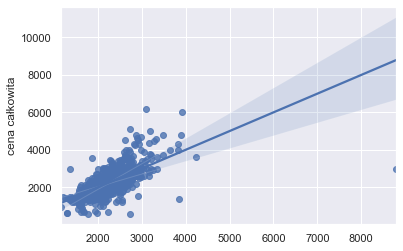

In [4]:
sns.regplot(x=prediction, y=y)

Model bez uwzględniania opisów radzi sobie całkiem dobrze, jednak pojawiają się punkty które znacząco odbiegają od predykcji. Być może metody pzetwarzania języka naturalnego będą potrafiły znaleźć pewne zależności i porpawić predyjkcję

In [5]:
df_waw_text['predykcja'] = lm.predict(X)
df_waw_text['predykcja'] = round(df_waw_text['predykcja'],2)

df_waw_text[df_waw_text['predykcja'] == df_waw_text['predykcja'].max()]

,dzielnica,od,poziom,zabudowa,powierzchnia,tytuł,opis,cena całkowita,predykcja
5,Wola,Biuro / Deweloper,1,Blok,400,2 pokoje z miejscem postojowym w Centrum przy ...,Na wynajem mieszkanie 2 pokoje w stanie idealn...,3000,8793.63


In [6]:
print(df_waw_text['opis'][df_waw_text['predykcja'] == df_waw_text['predykcja'].max()].to_markdown())

|    | opis                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            |
|---:|:------------------------------------------------------------------------------------------------------------------------

Jedna z predykcji jest wyjątkowo odległa od prawdy. Jest to jednak spowodowane błędem w ogłoszeniu. Z opisu wynika, że mieszkanie ma 40 metrów kwadratowych, natomiast w tabelce jest podane 400. 

<AxesSubplot:ylabel='cena całkowita'>

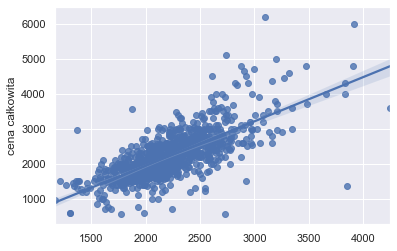

In [7]:
sns.regplot(x=np.delete(prediction, 5), y=y.drop(5))

Wykres regresji bez tej wartości wygląda znacznie lepiej. Jednak wciąż pojawiają się punkty które znacząco odbiegają od predykcji. Być może metody pzetwarzania języka naturalnego będą potrafiły znaleźć pewne zależności i porpawić predyjkcję. Usunę ją recznie, aby nie zaburzało mi to następnych wykresów.

In [8]:
drop_value(df_waw_text, 'predykcja', df_waw_text['predykcja'].max())

### EDA (Exploratory data analysis) pod kątem NLP

Tworzę kolumnę składniki resztowe

In [9]:
df_waw_text['składniki resztowe'] = df_waw_text['cena całkowita'] - df_waw_text['predykcja']
df_waw_text.head()

In [11]:
df_waw_group = df_waw_text.groupby('dzielnica')

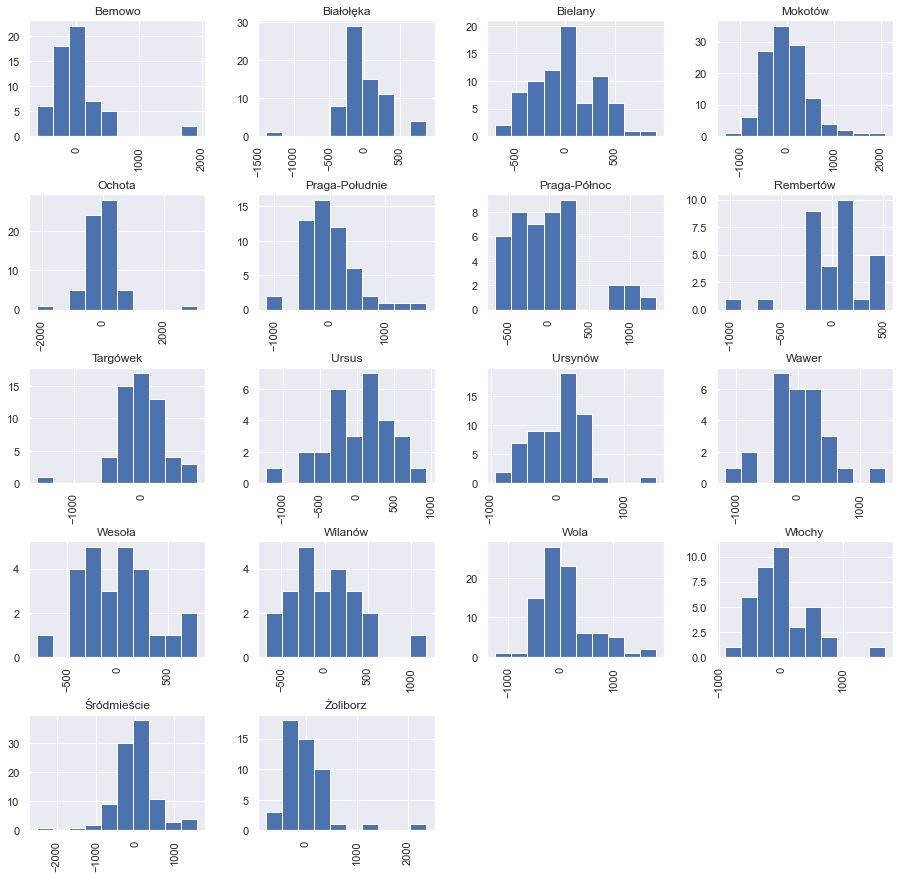

In [14]:
df_waw_text.hist(column='składniki resztowe', by='dzielnica', figsize=(15,15))
plt.show()

In [15]:
print(df_waw_text.median())
df_waw_group.median()

powierzchnia            40.00
cena całkowita        2195.00
predykcja             2195.24
składniki resztowe     -19.54
dtype: float64


,powierzchnia,cena całkowita,predykcja,składniki resztowe
dzielnica,,,,
Bemowo,45.5,2178.5,2247.835,-60.115
Białołęka,46.0,2001.0,2095.015,-67.535
Bielany,40.0,2101.0,2132.290,4.560
Mokotów,40.0,2200.0,2231.595,-42.535
Ochota,37.0,2101.0,2134.045,-13.470
Praga-Południe,47.5,2300.5,2309.120,-46.820
Praga-Północ,44.0,2301.0,2307.460,-14.160
Rembertów,38.0,1801.0,1778.140,70.060
Targówek,41.0,2001.0,2024.430,13.110


Mediana składników resztowych pokazuje, czy w danej dzielnicy większość cen jes zawyżonych (reszty dodatnie), czy zaniżonych (reszty ujemne).  *mediana dla Bemowa = -60.115, czyli 50% wszystkich predykcji jest niższa od ceny faktycznej o 60,12 zł*. Potwierdzenie togo widzać na wykresie powyżej.  
Z danych wynika, że model zawyża najbardziej ceny na Ursusie, Rembertowie i Ursynowie. Zaniża zaś na Żoliborzu, Bemowie i Białołęce. Najtrafniej ocenia mieszkania z Wawra, Wesołej, Śródmieścia i Bielan.  
Średnio dla całej Warszawy, większość predykcji jest nieznacznie zaniżona.

In [31]:
df_waw_group_abs = df_waw_group['składniki resztowe'].apply(abs)
df_waw_group_abs = pd.concat([df_waw_text.drop(['składniki resztowe'], axis=1), df_waw_group_abs], axis=1)

In [35]:
df_waw_group_abs.describe()

,powierzchnia,cena całkowita,predykcja,składniki resztowe
count,1011.000000,1011.000000,1011.000000,1011.000000
mean,42.828882,2235.282888,2229.552295,323.032532
std,15.855580,655.671979,377.197229,328.482567
min,2.000000,551.000000,1170.830000,1.320000
25%,32.000000,1801.000000,1999.780000,112.305000
50%,40.000000,2195.000000,2195.240000,238.520000
75%,50.000000,2550.000000,2428.700000,411.015000
max,160.000000,6200.000000,4248.120000,3105.310000


W tabeli powyżej przekształciłem kolumnę składnik resztowe w wartości absolutne (bez minusów). Dzięki temu mogę wyciągnąć średnią, która wynosi ok. 323,03. Model średnio mysli się taką wartość (bez uzględnienia w którą stronę). 

In [37]:
df_waw_text['tytuł długość'] = df_waw_text['tytuł'].str.split().apply(len)
df_waw_text['opis długość'] = df_waw_text['opis'].str.split().apply(len)

Liczę ilość słów w kolumnach tytuł i opis

In [38]:
df_waw_text.head()

,dzielnica,od,poziom,zabudowa,powierzchnia,tytuł,opis,cena całkowita,predykcja,składniki resztowe,tytuł długość,opis długość
0,Białołęka,Osoby prywatnej,1,Blok,46,Mieszkanie 49 m2 1300 zł + czynsz. Od zaraz,Do wynajęcia mieszkanie 49m2 na Białołęce przy...,1800,2101.59,-301.59,9,35
1,Ursynów,Osoby prywatnej,3,Blok,64,Wynajmę 3-pokojowe mieszkanie na Kabatach przy...,Wynajmę na co najmniej rok 3-pokojowe umeblowa...,3000,2591.80,408.20,7,228
2,Mokotów,Osoby prywatnej,8,Blok,85,Mieszkanie do wynajęcia Służew Bezpośrednio,Wynajmę bezpośrednio duże przestronne 85m2 mie...,2901,3135.60,-234.60,5,66
3,Ursynów,Osoby prywatnej,3,Blok,45,Wynajem mieszkanie Warszawa na Ursynowie,Witam \nWynajmę śliczne mieszkanie na Ursynowi...,2800,2235.95,564.05,5,79
4,Białołęka,Osoby prywatnej,Parter,Blok,29,Funkcjonalna kawalerka z miejscem parkingowym ...,Nowa kawalerka z miejscem parkingowym w cenie ...,1750,1706.18,43.82,7,79


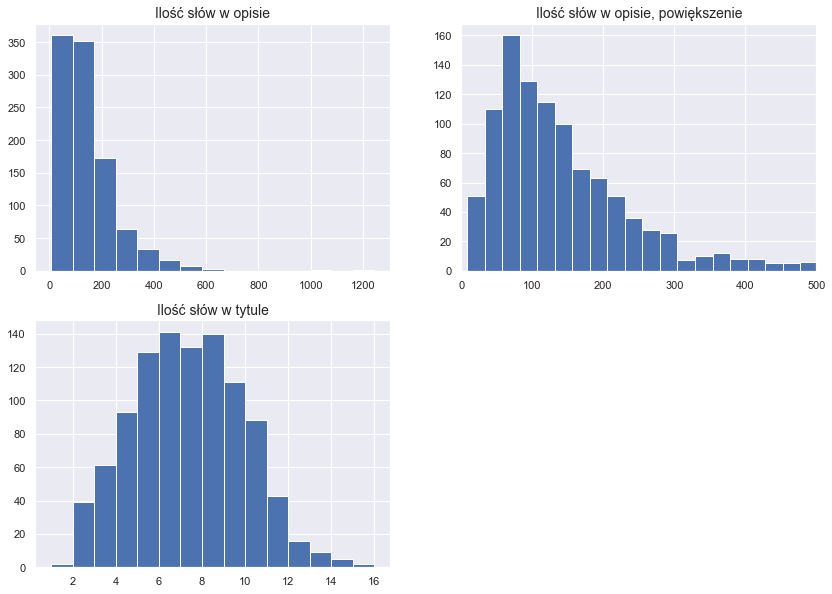

In [91]:
plt.figure(figsize=(14,10))

plt.subplot(2, 2, 3)
plt.hist(df_waw_text['tytuł długość'], bins=15)
plt.title('Ilość słów w tytule', fontdict={'fontsize':14})

plt.subplot(2, 2, 1)
plt.hist(df_waw_text['opis długość'], bins=15)
plt.title('Ilość słów w opisie', fontdict={'fontsize':14})

plt.subplot(2, 2, 2)
plt.hist(df_waw_text['opis długość'], bins=50)
plt.title('Ilość słów w opisie, powiększenie', fontdict={'fontsize':14})
plt.xlim(0, 500)
plt.show()

Większość opisów ogłoszeń liczy od 25 do 125 słów. Istnieje pare bardzo długich (ponad 600 słów). Większość tytułów posiada od 4 do 11 słów. Nie występują watrości zacząco odbiegające od średniej

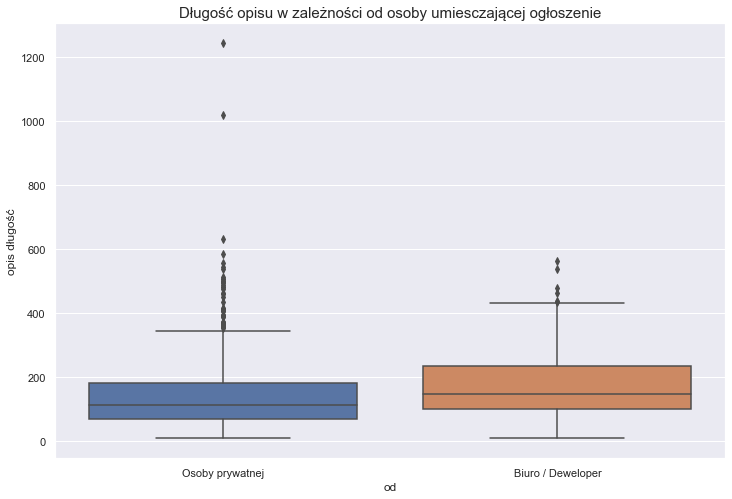

In [93]:
plt.figure(figsize=(12,8))
sns.boxplot(x=df_waw_text['od'], y=df_waw_text['opis długość'])
plt.title('Długość opisu w zależności od osoby umiesczającej ogłoszenie', fontdict={'fontsize':15})
plt.show()

Ogłoszenia od osób prywatnych są zazwyczaj krótsze, jednak często pojawiają się ogłoszenia o wiele dłuższe. Ogłoszenia od deweloperów są bardziej usystematyzowane. 

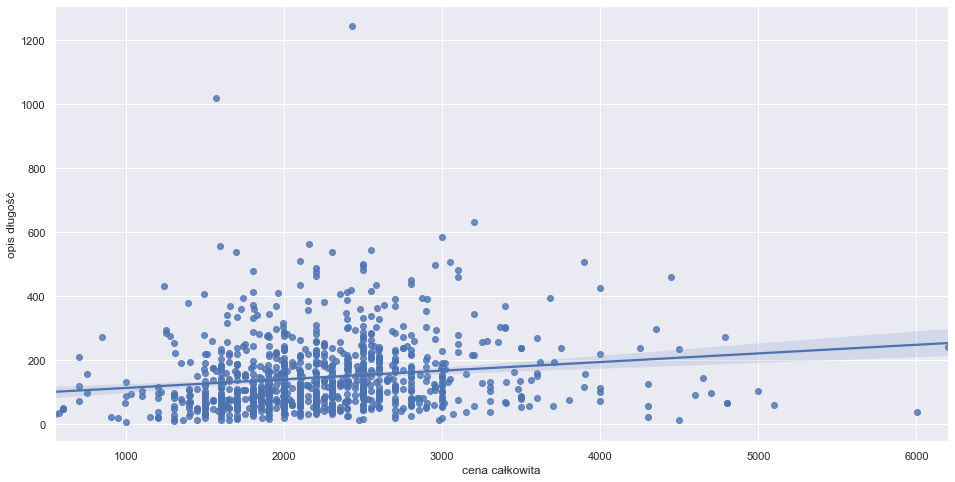

In [92]:
plt.figure(figsize=(16,8))
sns.regplot(x=df_waw_text['cena całkowita'], y=df_waw_text['opis długość'])
plt.show()

Liniowa zależność między długością opisu a ceną mieszkania nie występuje.

## Przetwarzanie tekstu

Czyszczenie tekstu

In [104]:
for i in range(20):
    print(df_waw_text.iloc[i]['opis'], '\n')

Do wynajęcia mieszkanie 49m2 na Białołęce przy ul. Aluzyjnej. Mieszkanie w pełni umeblowane, blok z 2004 roku z windą. Cena 1300 +  opłaty. Mieszkanie wolne od zaraz. Więcej info pod nr. tel. 602.783.370 Agencjom dziękuję 

Wynajmę na co najmniej rok 3-pokojowe umeblowane mieszkanie przy ul. Wąwozowej na Kabatach (Ursynów). W każdym pokoju podwójne łóżko (w salonie to rozkładana sofa), karnisze z kutego żelaza od artysty kowala, lampy od artysty szklarza. W kuchni lodówka, kuchenka gazowa, piekarnik i zmywarka. WC i łazienka oddzielne. W łazience jacuzzi, pralka i podgrzewana podłoga. W przedpokoju (obszernym) i jednym z pokojów duże szafy z systemem drzwi przesuwnych Raumplus. Na podłogach lita (grubość 5 cm) deska jesionowa. Jest balkon oraz dostęp do wspólnej komórki lokatorskiej (wspólnej dla mieszkańców klatki schodowej). Na wysokości 1. piętra patio z placem zabaw - wyłączny dostęp dla mieszkańców. Mieszkanie mieści się na 3. piętrze w 7-piętrowym bloku z 1999 roku. 100 metrów do

In [131]:
text = df_waw_text.iloc[1]['opis']

In [132]:
text = text.lower() # małe litery
text = re.sub('\w*\d\w*', '', text)

In [133]:
text

'wynajmę na co najmniej rok -pokojowe umeblowane mieszkanie przy ul. wąwozowej na kabatach (ursynów). w każdym pokoju podwójne łóżko (w salonie to rozkładana sofa), karnisze z kutego żelaza od artysty kowala, lampy od artysty szklarza. w kuchni lodówka, kuchenka gazowa, piekarnik i zmywarka. wc i łazienka oddzielne. w łazience jacuzzi, pralka i podgrzewana podłoga. w przedpokoju (obszernym) i jednym z pokojów duże szafy z systemem drzwi przesuwnych raumplus. na podłogach lita (grubość  cm) deska jesionowa. jest balkon oraz dostęp do wspólnej komórki lokatorskiej (wspólnej dla mieszkańców klatki schodowej). na wysokości . piętra patio z placem zabaw - wyłączny dostęp dla mieszkańców. mieszkanie mieści się na . piętrze w -piętrowym bloku z  roku.  metrów do stacji metra kabaty i tesco,  m do lasu kabackiego. w bezpośrednim sąsiedztwie sklepy, restauracje, apteka, basen, przedszkola i szkoły (również anglojęzyczne). spokojni i mili sąsiedzi. mieszkanie jest w pełni umeblowane. jeśli lokat